In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import math
import random
import itertools
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(1122)

Using cuda device


In [23]:
theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])


In [26]:
class DE_NN(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_NN, self).__init__()
        self.lin1s = nn.ModuleList([nn.Linear(1, 4) for i in range(NP)])
        self.lin2s = nn.ModuleList([nn.Linear(4, 8) for i in range(NP)])
        self.lin3s = nn.ModuleList([nn.Linear(8, 4) for i in range(NP)])
        self.lin4s = nn.ModuleList([nn.Linear(4, 1) for i in range(NP)])
        ranges1 = [range(dim_size) for dim_size in self.lin1s[0].shape]
        self.idxs1 = itertools.product(*ranges1)
        ranges2 = [range(dim_size) for dim_size in self.lin2s[0].shape]
        self.idxs2 = itertools.product(*ranges2)
        ranges3 = [range(dim_size) for dim_size in self.lin3s[0].shape]
        self.idxs3 = itertools.product(*ranges3)
        ranges4 = [range(dim_size) for dim_size in self.lin4s[0].shape]
        self.idxs4 = itertools.product(*ranges4)

        ranges = [range(dim_size) for dim_size in self.lin1s[0].shape]
        #self.num_params = self.lin1[0].numel() + self.lin2[0].numel() + self.lin3[0].numel() + self.lin4[0].numel()
        #print(self.num_params, 'params')
        self.NP = NP
        self.CR = CR
        self.F = F
    def forward_id(self, X, id):
        X = torch.relu(self.lin1s[id](X))
        X = torch.relu(self.lin2s[id](X))
        X = torch.relu(self.lin3s[id](X))
        return self.lin4s[id](X)
    def step(self, id, X, Y, L): # forward pass with candidate i
        fx = L(self.forward_id(X, id), Y)
        agent_ids = [a for a in random.sample(range(0, self.NP), 3) if a != id] # reject self
        y = {"lin1" : nn.Linear(1, 4), "lin2" : nn.Linear(4, 8), "lin3" : nn.Linear(8, 4), "lin4" : nn.Linear(4, 1)}

        # one R per layer
        R1 = tuple(torch.randint(0, dim) for dim in self.lin1s[id].shape)

        for i in self.idxs1:
            ri = torch.rand(0, 1)
            if ri < self.CR or i == R1:
                y.lin1[i] = self.lin1s[agent_ids[0]][i] + self.F * (self.lin1s[agent_ids[1]][i] - self.lin1s[agent_ids[2]][i])
            else: 
                y.lin1[i] = self.lin1s[id][i]
        
        # complete for other layers
        
        return
        

In [25]:
import torch.profiler

# 890 models or random candidates
# update individual parameters pi, 1 <= i <= 89 using unravel index but on each of the layers....
# 

epochs = 100

X = torch.randn(4000, 1).to(device)
Y = gaussian_mixture(X).to(device)

num_params = 89 #sum(p.numel() for p in model.parameters() if p.requires_grad)
NP = num_params * 10
CR = 0.9
F = 0.8

model = DE_NN(NP, CR, F).to(device)
L = nn.MSELoss().to(device)

#with torch.autograd.profiler.profile(use_device='cuda') as prof:
for e in range(epochs):
    #for model in models:
    with torch.no_grad():
        for i in range(model.NP):
            model.step(i, X, Y, L)
        
            #print(f"Epoch [{e+1}/{epochs}], Loss: {loss.item():.4f}")
            print(torch.cuda.utilization())
            #free, total = torch.cuda.mem_get_info(device)
            #mem_used_MB = (total - free) / 1024 ** 2
            #print(mem_used_MB)
            #print(torch.cuda.memory_summary())
    #nvidia-smi -lms 100 --query-gpu=index,gpu_name,memory.total,memory.used,memory.free,temperature.gpu,pstate,utilization.gpu,utilization.memory --format=csv

#print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#prof.export_chrome_trace("trace_with_grad_GPU.json")

Epoch [1/100], Loss: 1.3563
890
26
Epoch [1/100], Loss: 1.4320
890
26
Epoch [1/100], Loss: 1.5415
890
26
Epoch [1/100], Loss: 0.9711
890
26
Epoch [1/100], Loss: 0.4061
890
26
Epoch [1/100], Loss: 0.7329
890
26
Epoch [1/100], Loss: 1.0494
890
26
Epoch [1/100], Loss: 1.5054
890
26
Epoch [1/100], Loss: 1.5048
890
26
Epoch [1/100], Loss: 0.5619
890
26
Epoch [1/100], Loss: 0.4951
890
26
Epoch [1/100], Loss: 1.3265
890
26
Epoch [1/100], Loss: 1.4791
890
26
Epoch [1/100], Loss: 1.8859
890
26
Epoch [1/100], Loss: 0.7885
890
26
Epoch [1/100], Loss: 0.9261
890
26
Epoch [1/100], Loss: 2.0416
890
26
Epoch [1/100], Loss: 1.4740
890
26
Epoch [1/100], Loss: 0.5788
890
26
Epoch [1/100], Loss: 0.7909
890
26
Epoch [1/100], Loss: 1.5926
890
26
Epoch [1/100], Loss: 1.8853
890
26
Epoch [1/100], Loss: 1.8937
890
26
Epoch [1/100], Loss: 1.9030
890
26
Epoch [1/100], Loss: 1.3353
890
26
Epoch [1/100], Loss: 0.7484
890
26
Epoch [1/100], Loss: 2.0186
890
26
Epoch [1/100], Loss: 0.5978
890
26
Epoch [1/100], Loss:

KeyboardInterrupt: 

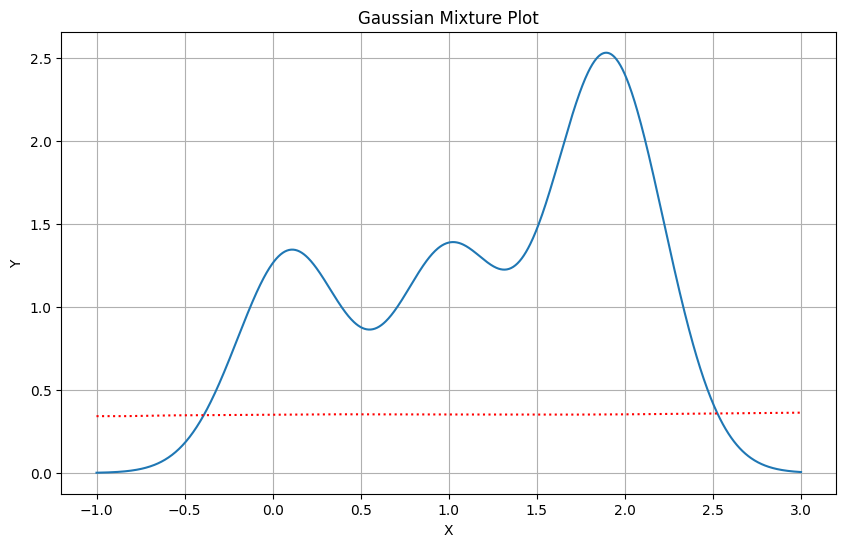

In [5]:
test_X = torch.linspace(-1, 3, 1000)
test_Y = gaussian_mixture(test_X)
model_Y = model(test_X.reshape(-1, 1).to(device))
model_Y = model_Y.cpu()
plt.figure(figsize=(10, 6))
plt.plot(test_X.numpy(), test_Y.numpy(), label='Gaussian Mixture')
plt.plot(test_X.numpy(), model_Y.detach().numpy(), label='Predictions', color='red', linestyle='dotted')
plt.title('Gaussian Mixture Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()